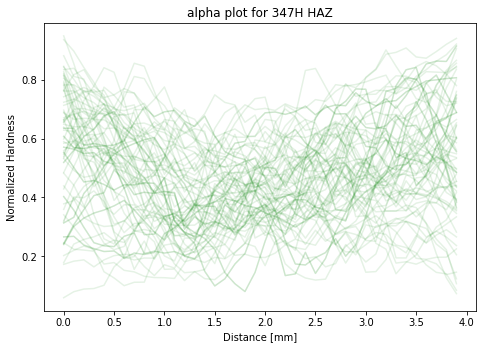

In [1]:
'''
So we have an array for the HAZ, FZ, and HAZ. We really only need the average HAZ and FZ values now.
However, for the HAZ, we have a list of all the values, which should be averaged to a 1 dimensional array.
Essentially right now we have a 2,3,or 4 dimensional array in a 1D form. Hence why we have a "width"
column. This "width" column tells us what dimension our data is in.
'''
from scipy.signal import savgol_filter
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt
import pandas as pd
from itertools import zip_longest
import matplotlib as mpl
import seaborn as sns
import pylab
import math
from operator import itemgetter
import re

def convert (str_array):
    array = list(str_array.split("["))
    array = list(array[1].split("]"))
    array = list(array[0].split(" "))
    
    real_array = []
    for x in array:
        real_array.append(float(x))
    
    return real_array

#this just makes it so that the first point is always in the same place
#UPDATE 10/24: do we need this?
#def first_point_normalize (array):
    

def graph_HAZ_average (hardness, material):
    #we want just the HAZ data for 347H and 740H, but we want them to be seperate
    re_array = ['Material', material, 'Type', 'HAZ']
    
    #this loop takes the whole set of data and refines it down to the HAZ info
    count = 0
    for x in range(2):
        hardness = hardness[hardness[re_array[count]]==re_array[count+1]]
        count +=2
        
    #lets get our plot together
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.set_title("alpha plot for {} HAZ" .format(material))
    ax.set_xlabel('Distance [mm]')
    ax.set_ylabel('Normalized Hardness')
    
    #'''
    #our first step is to look for where the HAZ ends and the base metal begins
    #easiest to plot all the data as an alpha plot
    
    #this for loop is giving an average value for an array, and creating a list of (time, average hardness)
    for index in hardness.index.values:
        array = hardness.at[index,'Average'] #this should be the shortened and averaged HAZ (2-3 wide to 1 average)
        #if we want to plot the alpha, we need to first normalize the data
        #a few different options to normalize data:
        maxi = np.amax(array)
        mini = np.amin(array)
        #maxi=550
        #mini=300
        diff = maxi-mini
        min_max_normalize = lambda value, mini, diff: (value-mini)/diff #this is the classic normalize
        subtract_min_normalize = lambda value, mini: value - mini #this just removes the min from all values
        divide_max_normalize = lambda value, maxi: value/maxi #this makes it so the peak is always at 1
        
        HAZ_normalize = []
        
        #we also want the x-values for our data
        distance_count = 0.0
        distance = []
        
        for value in array:
            normalized = min_max_normalize (value, mini, diff) 
            #normalized = subtract_min_normalize (value, mini) 
            #normalized = divide_max_normalize (value, maxi)
            HAZ_normalize.append(normalized)
            distance.append(distance_count)
            distance_count += 0.1
        
        #ok lets filter the data
        #a widow of 21-31 (25) and a poly of 3 was chosen based on the work done in the SavGol filter test.ipynb
        if material == '740H':
            HAZ_filtered = savgol_filter(HAZ_normalize, 25, 2, mode='nearest')
        else:
            HAZ_filtered = savgol_filter(HAZ_normalize, 11, 3, mode='nearest')
            #HAZ_filtered = HAZ_normalize
        
        #HAZ_filtered = first_point_normalize (HAZ_filtered)
            
        #now lets plot
        plt.plot(distance,HAZ_filtered,color='green',alpha=0.1)
        
#from: https://stackoverflow.com/questions/434287/what-is-the-most-pythonic-way-to-iterate-over-a-list-in-chunks
#this function takes a list and seperates it into chunks of size n
def grouper(iterable, n, fillvalue=None):
    args = [iter(iterable)] * n
    return zip_longest(*args, fillvalue=fillvalue)

#this function takes the hardness array for the HAZ and averages it so it's 1D
def haz_average (hardness, index, array):
    width = hardness.at[index,'Width']
    average_value = []
    fill = np.mean((array[-3],array[-2],array[-1])) #we can't fill the grouper function with none
    chunk_array = grouper(array,width,fill)
    for chunk in chunk_array:
        #print (chunk)
        mean_value = np.mean(chunk)
        average_value.append(mean_value)
    return average_value

#this function takes the dataframe hardness as input and outputs a dataframe where all the FZ and BM
#values are averaged and the HAZ is reduced to one dimension
def hardness_type_average (hardness_input):
    hardness = hardness_input
    #we need to initialize the new column we're making, Average and Variance
    hardness['Average']=''
    hardness['Variance']=''
    hardness.Average=hardness.Average.astype(object)
    hardness.Variance=hardness.Variance.astype(object)
    
    #this for loop is giving an average value for an array, and creating a list of (time, average hardness)
    for index in hardness.index.values:
        hardness_type = hardness.at[index,'Type']
        str_array = hardness.at[index,'Hardness']
        array = convert (str_array)
        hardness.at[index,'Hardness'] = array #this changes the dataframe permenantly, no need to convert again
        
        if hardness_type=='FZ':
            average_value = sum(array)/len(array)
            st_dev = np.std(array)
            hardness.at[index,'Variance'] = [st_dev]
            hardness.at[index,'Average'] = np.array([0, average_value])
        elif hardness_type=='BM':
            material = hardness.at[index,'Material']
            average_value = sum(array)/len(array)
            st_dev = np.std(array)
            hardness.at[index,'Variance'] = [st_dev]
            #i'm cheating a bit, we're shortening all average arrays to length 40, so CHANGE if that changes
            hardness.at[index,'Average'] = np.array([4.1, average_value])
        else:
            average_array = haz_average(hardness, index, array)
            hardness.at[index,'Average'] = average_array
    
    return hardness

def get_minimum_size (hardness):
    #we start by going through all the average arrays
    minimum_size_740H =500 #initialize to be very big so we can change it to be smaller
    minimum_size_347H = 500
    total=0
    count=0
    
    for index in hardness.index.values:
        material = hardness.at[index,'Material']
        hardness_type = hardness.at[index,'Type']
        size = len(hardness.at[index,'Average'])
        it_together = (material, hardness_type)
        
        #this statement changes minimum_size of either 347H or 740H only if its HAZ and that material
        if '740H' in it_together and 'HAZ' in it_together: #heh in it together get it haha wow its 8pm and i'm still at the office
            if size<=minimum_size_740H:
                minimum_size_740H=size
        elif '347H' in it_together and 'HAZ' in it_together:
            total+=size
            count+=1
            
            if size<=minimum_size_347H:
                minimum_size_347H=size
    
    return (minimum_size_740H, minimum_size_347H,total/count)
'''
This function takes the dataframe hardness and trims the average HAZ array we generated before so they're
all the same size. What joy. What celebration.
'''
def haz_length_trim (hardness):
    (minimum_size_740H,minimum_size_347H,average_347H_length) = get_minimum_size (hardness)
    #minimum_size_347H = int(average_347H_length-1) #the minimum for 347H is 38, but the average is 56. 
    #I feel bad about throwing away 18 points on average
    minimum_size_347H = 40 #just to round up a bit, the shorter arrays of 38 will have two artifical points added on
    
    for index in hardness.index.values:
        material = hardness.at[index,'Material']
        hardness_type = hardness.at[index,'Type']
        haz_array = np.array(hardness.at[index,'Average'])
        it_together = (material, hardness_type)
        
        if '740H' in it_together and 'HAZ' in it_together:
            short_array = np.resize(haz_array,(minimum_size_740H,))
            hardness.at[index,'Average'] = short_array
        elif '347H' in it_together and 'HAZ' in it_together:
            short_array = np.resize(haz_array,(minimum_size_347H,))
            hardness.at[index,'Average'] = short_array
        
    return hardness

#hardness_i = pd.read_csv(r'C:\Users\DuchJ\Desktop\PhD Please\18. Hardness and Precipiate Modeling\all_data_width.csv')
hardness_i = pd.read_csv('all_data_width.csv')
hardness = hardness_type_average(hardness_i) #this function adds an Average and stdev column to the dataframe
hardness_avg = haz_length_trim (hardness) #this function makes all the HAZ the same size (different for 347H and 740H tho)
#graph_HAZ_average (hardness, '740H')
graph_HAZ_average (hardness, '347H')

In [2]:
'''_________________________________________________________________________________________
Lets do some machine learning here, we want to run PCA on our HAZ data. 
What do we need for PCA? 
1. We need to have a list (or numpy array) that is organized like [[x1,y1], [x2,y2],...[xn,yn]].
Y is our hardness data, X is generated by a list of length len(Y) long seperated by 0.1 mm.
The function scatter_hard will take our dataframe hardness as an input and add another column
"Scatter" which will have data organized in this way (y values will come from the "Average" 
column and x values depend on y values)
_________________________________________________________________________________________'''

def scatter_hard (hardness):
    #we're gonna do the classic thing and use a for loop to iterate through our dataframe
    #first we have to initialize the new column we are making
    #hardness['Scatter']='' #if we're overwriting average, we don't need another column
    #hardness.Scatter=hardness.Scatter.astype(object)
    #this will be blank if we don't save anything to it, otherwise it will contain the 2d array
    min_max_normalize = lambda value, mini, diff: (value-mini)/diff
    
    for index in hardness.index.values:
        material = hardness.at[index,'Material'] #we don't use this, but good for testing code
        hardness_type = hardness.at[index,'Type']
        y_values = hardness.at[index,'Average']
        #print (y_values)
        x_values = np.arange(0.1,(len(y_values)/10.)+0.1,0.1)
        
        #we're only doing calculations for HAZ material
        if hardness_type == 'HAZ': 
            #'''if we were to normalize the y values
            mini = min (y_values)
            diff = max(y_values)-mini
            normalized = []
            for value in y_values:
                norm= min_max_normalize(value, mini, diff)
                normalized.append(norm)
            #'''

            scatter = np.array([x_values,normalized]).transpose()
            #scatter = np.array([x_values,y_values]).transpose()
            #without the transpose it would be [ [x1,x2,...xn] , [y1,y2,...yn] ]
            
            #hardness.at[index,'Scatter'] = scatter
            hardness.at[index,'Average'] = scatter #this will overrite the value at Average
    
    return hardness
    #hardness_HAZ = hardness[hardness['Type']=='HAZ']
    #print(hardness_HAZ.head())
    
hardness_scatter = scatter_hard (hardness_avg.copy())
#print(hardness_scatter.head())

[(-3, 3.1),
 Text(0, 0.5, 'component 2'),
 (-5, 5),
 Text(0.5, 0, 'component 1'),
 Text(0.5, 1.0, 'principal components')]

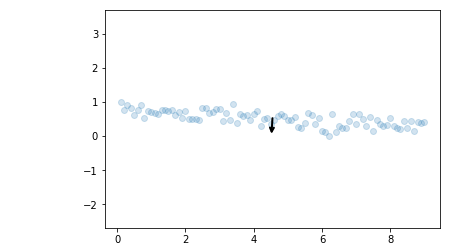

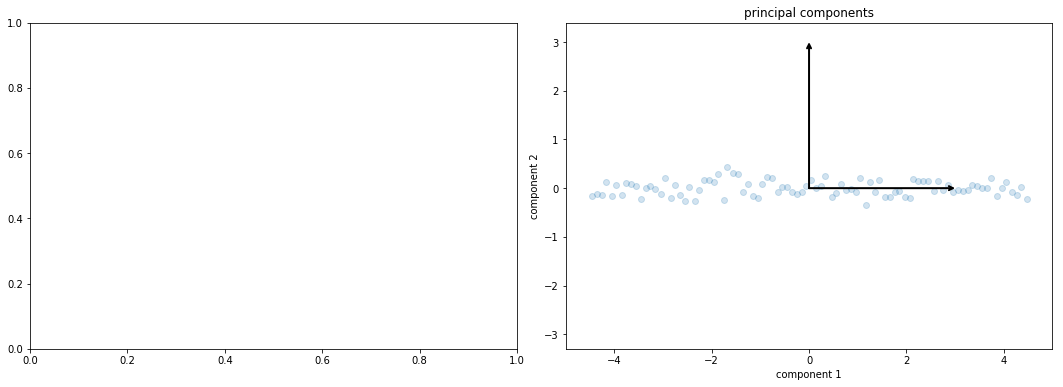

In [3]:
'''_________________________________________________________________________________________
2. Since we then have our values set up, lets run it through PCA. Just one of them why not.
_________________________________________________________________________________________'''
from sklearn.decomposition import PCA
import random

def draw_vector(v0, v1, ax=None):
    ax = ax or plt.gca()
    arrowprops=dict(arrowstyle='->',
                    linewidth=2,
                    shrinkA=0, shrinkB=0, color='black')
    ax.annotate('', v1, v0, arrowprops=arrowprops)
    
#ok lets do PCA on the first HAZ vector (its at index 0)
X = hardness_scatter.at[0,'Average']
pca = PCA(n_components=2)
pca.fit(X)

plt.scatter(X[:, 0], X[:, 1], alpha=0.2)
for length, vector in zip(pca.explained_variance_, pca.components_):
    v = vector * 3 * np.sqrt(length)
    draw_vector(pca.mean_, pca.mean_ + v)
plt.axis('equal');

fig, ax = plt.subplots(1, 2, figsize=(16, 6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

X_pca = pca.transform(X)
ax[1].scatter(X_pca[:, 0], X_pca[:, 1], alpha=0.2)
draw_vector([0, 0], [0, 3], ax=ax[1])
draw_vector([0, 0], [3, 0], ax=ax[1])
ax[1].axis('equal')
ax[1].set(xlabel='component 1', ylabel='component 2',
          title='principal components',
          xlim=(-5, 5), ylim=(-3, 3.1))

In [13]:
#from: https://stackoverflow.com/questions/12680754/split-explode-pandas-dataframe-string-entry-to-separate-rows

hard_df = hardness_scatter.copy() #we'll be modifying a copy of the dataframe so we don't alter the original
hard_df.drop('Hardness', axis=1, inplace=True) #we're not using the raw data any more, it should all be in average and variance
hard_df.drop('Width', axis=1, inplace=True)
hard_df.drop('Unnamed: 0', axis=1, inplace=True)
#list(hard_df.columns.values)
values = {'Composition': 0}
hard_df = hard_df.fillna(value=values)
#hard_df = hard_df.replace([0.04, 0.08], [1,2], inplace=True)
#print (len(hardness.at[357,'Average']))

'''
For this part of the code, we're going to save a new row for every value in the HAZ. No longer will we have:
[0.1, 1.0], [0.2, 0.7528089887640438] ... but instead just have [0.1, 1.0], next row [0.2, 0.7528089887640438]
We do this by putting in the extra rows as sub indexes. For index 2 for example, we will have 2.1, 2.2,2.3, etc.
Since hard_df.index.values is a list of whole numbers, it should skip over the float indexes.
Hopefully float indexes will work.
'''
hard_split = pd.DataFrame(columns = ['Composition','Material','Strain','Temperature','Time','Type','Average','Variance','Position'])
hard_split_index = 0

for index in hardness.index.values:
    composition = hard_df.at[index,'Composition']
    material = hard_df.at[index,'Material']
    strain = hard_df.at[index,'Strain']
    temperature = hard_df.at[index,'Temperature']
    time = hard_df.at[index, 'Time']
    hardness_type = hard_df.at[index,'Type']
    y_values = hard_df.at[index,'Average'] #this has the structure [[x1,y1], [x2,y2],...]
    variance = hard_df.at[index,'Variance']
    
    if hardness_type == 'HAZ' and len(y_values)>2:
        for pair in y_values:
            hard_split.loc[hard_split_index] = [composition, material, strain, temperature, time, hardness_type, pair[1],variance,pair[0]]
            hard_split_index+=1
    else:
        hard_split.loc[hard_split_index] = [composition, material, strain, temperature, time, hardness_type, y_values[1],variance,y_values[0]]
        hard_split_index+=1
       
 
print(hard_split.head)
#hard_df_reset = hard_df.reset_index(level=0, drop=True)

<bound method NDFrame.head of        Composition Material Strain Temperature   Time Type   Average Variance  \
0             0.00     740H      0         700    0.0  HAZ  1.000000            
1             0.00     740H      0         700    0.0  HAZ  0.752809            
2             0.00     740H      0         700    0.0  HAZ  0.915730            
3             0.00     740H      0         700    0.0  HAZ  0.837079            
4             0.00     740H      0         700    0.0  HAZ  0.623596            
5             0.00     740H      0         700    0.0  HAZ  0.758427            
6             0.00     740H      0         700    0.0  HAZ  0.904494            
7             0.00     740H      0         700    0.0  HAZ  0.539326            
8             0.00     740H      0         700    0.0  HAZ  0.730337            
9             0.00     740H      0         700    0.0  HAZ  0.719101            
10            0.00     740H      0         700    0.0  HAZ  0.691011           

In [35]:
# Import module to split dataset
from sklearn.model_selection import train_test_split
# Import module for fitting
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.svm import SVR
'''_________________________________________________________________________________________
3. Lets get dum-
my variables
_________________________________________________________________________________________'''
hard_split_i = hard_split.copy()
#'''
alloy = pd.get_dummies(hard_split_i['Material'], drop_first=True)
hardness_type = pd.get_dummies(hard_split_i['Type'], drop_first=True)

# Use  .concat() method to merge the series data into one dataframe
hard_split_i = pd.concat([hard_split_i, alloy, hardness_type], axis=1)
#'''
hard_split_i.drop(['Material','Type','Variance'], axis=1, inplace=True)

'''_________________________________________________________________________________________
4. Lets put this in the form so that we can start doing machine learning
_________________________________________________________________________________________'''
# Split data into 'X' features and 'y' target label sets
hard_split_i.head()
X = hard_split_i[['Composition', 'Strain', 'Temperature', 'Time', 'Position', '740H', 'FZ',
                  'HAZ']]
y = hard_split_i['Average']

'''_________________________________________________________________________________________
5. Now lets get our test train split
_________________________________________________________________________________________'''
# Split data set into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=100)

'''_________________________________________________________________________________________
6. Create and Train Model
_________________________________________________________________________________________'''
# Create instance (i.e. object) of LogisticRegression
logmodel = LogisticRegression()
svr_model = SVR()

# Fit the model using the training data
# X_train -> parameter supplies the data features
# y_train -> parameter supplies the target labels
#logmodel.fit(X_train, y_train)
svr_model.fit(X_train, y_train)

'''_________________________________________________________________________________________
7. Lets see how well we did
_________________________________________________________________________________________'''
#predictions = logmodel.predict(X_test)
predictions = svr_model.predict(X_test)
print(classification_report(y_test, predictions))

C:\Users\DuchJ\Anaconda3\lib\site-packages\sklearn\svm\base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


ValueError: continuous is not supported